In [3]:
from stat_util import *
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import linalg
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.covariance import GraphLassoCV, ledoit_wolf
import codecs, sys
sns.set()


sys.stdout = codecs.getwriter('utf-8')(sys.stdout)
float_formatter = lambda x: "%.6f" % x
np.set_printoptions(threshold=10000,
                    linewidth=100,
                    formatter={'float_kind':float_formatter})

In [4]:
import cPickle as pickle
import glob
users = []
for u_name in glob.glob("../data/textunit/*"):
    #print u_name
    try:
        users+= pickle.load(open(u_name))
    except:
        pass
u_tmp2 = users

In [3]:
len(users)

7621

In [4]:
from textunit import TextUnit
from twitter_dm.utility.general_utils import read_grouped_by_newline_file
from constraints import get_id_and_value_map
import io
import sys
import codecs
from constraints import IDENTITY_PREFIX, SENTWORD_PREFIX
from collections import defaultdict

sys.stdout = codecs.getwriter('utf-8')(sys.stdout)

# read in sentiment word values
sent_dict = {}
for x in io.open("../data/all_epa_terms.txt"):
    x_spl = x.split("\t")
    sent_dict[x_spl[0]] = [float(z) for z in x_spl[1:]]

# make up identity values

identities = {'algerian', 'bahrainian', 'egyptian', 'iranian', 'iraqi', 'jordanian', 'kuwaiti', 'kuwaitian', 
              'lebanese', 'libyan', 'moroccan', 'omani', 'qatari', 'saudi', 'saudi arabian', 'syrain', 'tunisian', 
              'emirati', 'yemeni', 'american', 'russian', 'british', 'myself as i really am', 'woman', 'man', 'boy', 
              'girl', 'boyfriend', 'bf', 'girlfriend', 'gf', 'arab', 'muslim', 'terrorist', 'jew', 'christian', 
              'sunni', 'shiite', 'dictator', 'president', 'demonstrator', 'protestor', 'jerk', 'ruler', 'dumbass',
              'teacher', 'student', 'father', 'mother', 'brother', 'sister', 'daughter', 'son', 'husband', 'wife', 
              'gunman', 'enemy', 'terrorist', 'father', 'palestinian', 'netanyahu', 'obama', 'activist', 'soldier',
              'daughter', 'woman', 'officer', 'israel', 'iranians', 'muslims', 'militant', 'wife', 'policeman',
              'u.s.', 'police', 'islamists', 'iraq', 'guard', 'judge', 'iran', 'bush', 'syria', 'regime', 
              'criminal', 'israeli', 'child', 'murderer', 'insurgent', 'mother', 'abbas', 'army', 'washington', 
              'ally', 'killer', 'taliban', 'rebel', 'democrat', 'administration', 'assange', 'attacker', 'china', 
              'republican', 'jerusalem', 'thug', 'scientist', 'sniper', 'barak', 'laden', 'protester', 'husband', 
              'dictator', 'king', 'militiaman', 'politician', 'athlete', 'al-qaeda', 'expert', 'civilian', 'hero', 
              'extremist', 'taleban', 'taliban', 'mccain', 'assad', 'teacher', 'al-assad', 'sister', 'pentagon', 
              'christian', 'sunni', 'youth', 'refugee', 'smuggler', 'teenager', 'mercenary', 'tunisian', 'pirate', 
              'reporter', 'protestor', 'thief', 'gaddafi', 'al-qadhafi', 'prisoner', 'migrant', 'qaddafi', 'gadhafi',
              'revolutionary', 'al-asad', 'al-assad', 'baby', 'hostage', 'morsi'}

identity_dict = {x.strip().lower() : sent_dict.get(x.strip().lower(), [0.,0.,0.]) for x in identities}

identity_to_id, identity_values = get_id_and_value_map(identity_dict, IDENTITY_PREFIX)
id_to_identity = {v:k for k,v in identity_to_id.items()}
sent_to_id, sent_values = get_id_and_value_map(sent_dict,SENTWORD_PREFIX)

id_to_sent = {v:k for k,v  in sent_to_id.items()}

gram_list = set(identity_to_id.keys())|set(sent_to_id.keys())

In [5]:
# association matrix data
from gensim import corpora, models, similarities
from gensim.matutils import corpus2dense

texts = [u.identities for u in users]
dictionary = corpora.Dictionary(texts) 
dictionary.filter_extremes(no_below=300)
print dictionary
corpus = [dictionary.doc2bow(u.identities) for u in users]

corp_mat = corpus2dense(corpus,len(dictionary))

print 'SHAPE: ', corp_mat.shape

for i,u in enumerate(users):
    u.identities_vector = corp_mat[:,i]
    
row_to_identity = {k:v for k,v in dictionary.items()}
identity_to_row = {id_to_identity[v]:k for k,v in row_to_identity.items()}

Dictionary(79 unique tokens: [u'i_116', u'i_115', u'i_114', u'i_111', u'i_93']...)
SHAPE:  (79, 7621)


In [6]:
u2 = [u for u in users if u.identities_vector.sum() > 50]
u_tmp = users
users = u2

In [8]:
import numpy as np
from stat_util import *


# construct identity values list from shrunk down data
identity_to_values_small = {}
for v in dictionary.values():
    identity_to_values_small[v+'e'] = identity_values[v+'e']
    identity_to_values_small[v+'p'] = identity_values[v+'p']
    identity_to_values_small[v+'a'] = identity_values[v+'a']
    
n_users = len(users)
n_identity_sent_values = len(identity_to_values_small)
nu = float(n_identity_sent_values + 2.)
kappa = 10.
beta = 2.

In [10]:
# need to map rows to indices
index_to_ids = sorted(identity_to_values_small.keys())
ids_to_index = {v : i for i,v in enumerate(index_to_ids)}

# construct prior correlation matrix
expected_variance = 100
ep_correlation = 50
pa_correlation = 30
ea_correlation = 30

mu_0 = np.array([identity_to_values_small[k] for k in index_to_ids])


sigma_0 = np.identity(n_identity_sent_values)*expected_variance
for v in dictionary.values():
    e_ind = ids_to_index[v+'e']
    p_ind = ids_to_index[v+'p']
    a_ind = ids_to_index[v+'a']
    if mu_0[e_ind] == 0:
        sigma_0[e_ind,e_ind] += 100
        sigma_0[p_ind,p_ind] += 100
        sigma_0[a_ind,a_ind] += 100
    sigma_0[e_ind,p_ind] = sigma_0[p_ind,e_ind] = ep_correlation #* sigma_0[e_ind,e_ind]* sigma_0[p_ind,p_ind]
    sigma_0[e_ind,a_ind] = sigma_0[a_ind,e_ind] = ea_correlation #* sigma_0[e_ind,e_ind]* sigma_0[a_ind,a_ind]
    sigma_0[p_ind,a_ind] = sigma_0[a_ind,p_ind] = pa_correlation #* sigma_0[a_ind,a_ind]* sigma_0[p_ind,p_ind]


# todo: use identity_values

sigma = sample_invwishart(sigma_0,nu+100)
mu = np.random.multivariate_normal(mu_0, sigma/kappa)

precision_matrix = np.linalg.inv(sigma)
# todo: draw ?
phi = np.random.multivariate_normal(mu,sigma, n_users)

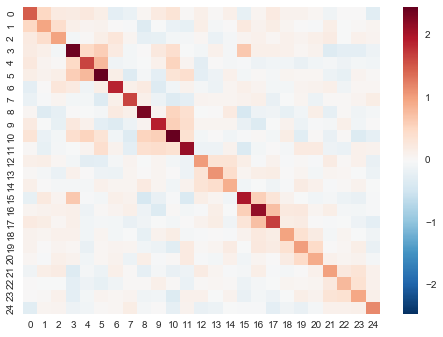

In [11]:
sns.heatmap(sigma[:25,:25])

In [19]:
for i in range(5):
    if i % 10 == 0:
        print i
    for u_it, u in enumerate(users):
        # have to "recreate" identity_values
        user_identity_values = {index_to_ids[i] : phi[u_it, i]
                           for i in range(n_identity_sent_values)}
        
        u_phi = phi[u_it]
        for k, identity_id in enumerate(index_to_ids):
            prior_var = 1/precision_matrix[k,k]
            
            prior_mean = np.dot(precision_matrix[:, k], (u_phi - mu))
            prior_mean -= precision_matrix[k,k] * (u_phi[k] - mu[k])
            prior_mean = mu[k] - prior_var*prior_mean

            sent_for_identity = u.identities_to_tweets[index_to_ids[k]]
            if not len(sent_for_identity):
                u_phi[k] = np.random.normal(prior_mean, sqrt(prior_var))
                continue

            c0_all = np.zeros(len(sent_for_identity))
            c1_all = np.zeros(len(sent_for_identity))
            for sent_it,sentence in enumerate(sent_for_identity):
                c0, c1 = sent_for_identity[sent_it].compute_constants_for_identity(identity_id,
                                                                                   sentiment_values,
                                                                                   user_identity_values)
                c0_all[sent_it] = c0
                c1_all[sent_it] = c1

            x_i = -(c1_all/(2*c0_all))
            s_i = beta/(2*c0_all)

            var = 1./(1./prior_var + (1./s_i).sum())
            b = prior_mean/prior_var + (x_i/s_i).sum()
            exp_mean = b*var
            u_phi[row_index] = np.random.normal(exp_mean, sqrt(var))

    mu, sigma = sample_gaussian(phi, n_identity_sent_values, n_users, mu_0, sigma_0,nu, kappa)
    precision_matrix = np.linalg.inv(sigma)
    
    # compute perplexity

0


In [13]:
from twitter_dm.utility.general_utils import tab_stringify_newline as tsn

np.savetxt("phi.txt",phi)

c = open("phi_labels.txt","w")
for i in range(len(index_to_ids)):
    c.write(tsn([id_to_identity[index_to_ids[i][:-1]], index_to_ids[i][-1], mu[i], mu_0[i],  mu[i]-mu_0[i],i]))
c.close()

In [2]:
import pandas as pd

z = []
for i in range(len(index_to_ids)):
    z.append([id_to_identity[index_to_ids[i][:-1]], index_to_ids[i][-1], mu[i], mu_0[i],  mu[i]-mu_0[i],i])
z = pd.DataFrame(z)
z.columns = ['name','epa','mu','mu_0','sub', 'i']
z.sort('mu', inplace=True)
plt.figure(figsize=(7, 15))
sns.barplot(x='name',y='mu',data=z[(z.mu_0 == 0) & (z.epa=='e')],palette="Blues_d")

NameError: name 'index_to_ids' is not defined

0.00942335318852 1.45238754094
0.197850390359 1.76422706915


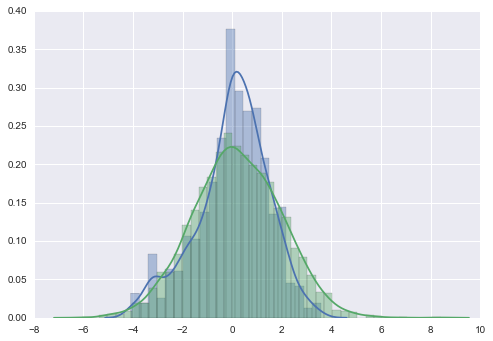

In [21]:
from sympy import Symbol
tot_vals = []
name = 'extremist'
id_v = identity_to_id[name]
for u in users:
    vals = []
    for k in u.identities_to_tweets[id_v]:
        if id_v in k.identities_to_constraint_string_map:
            q = {str(s)[:-1] for s in k.identities_to_constraint_string_map[id_v].atoms(Symbol)}
            if id_v in q:
                q.remove(id_v)
            v = []
            for x in q:
                if x in id_to_sent:
                    v.append(id_to_sent[x])
                    vals.append(sent_values[x+'e'])
                elif x in id_to_identity:
                    v.append(id_to_identity[x])
                    vals.append(identity_values[x+'e'])
            #print " ".join(v)
    if len(vals):
        tot_vals.append(np.array(vals).mean())
sns.distplot(tot_vals)
print np.array(tot_vals).mean(),np.array(tot_vals).std()

sns.distplot(phi[:,int(z[(z.name==name) & (z.epa=='e')].i)])
print phi[:,int(z[(z.name==name) & (z.epa=='e')].i)].mean(), phi[:,int(z[(z.name==name) & (z.epa=='e')].i)].std()

In [ ]:
users[0]